<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/preprocessing_scripts/fmri_dementia_data_preprocessing_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os
import gc
import copy
from tqdm.notebook import tqdm
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

from joblib import Parallel, delayed

!pip install -qU tsai
from tsai.all import *

!pip install -qU tsfresh
import tsfresh
from tsfresh.feature_extraction import extract_features

!pip install -qU PyWavelets
import pywt

# Connect to Google Drive and set cd

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/

/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia


# Data preprocessing:
* train/val/test split
* standardization
* converting data into array form

## Import raw data

In [ ]:
labels = pd.read_csv('./group_csv_files/labels_new_final.csv')

In [ ]:
labels['class'].replace(to_replace = {'AD': 0, 'FTD': 1, 'HC': 2, 'MCI' : 3}, inplace = True)
labels.head()

,class,patient_original_id,fmri_id_in_database,subject_id_in_dataset,valid_scans,invalid_scans,perc_invalid
0,0,002_S_5018,rs_fMRI_1',1.txt,111,29,0.21
1,0,002_S_5018,rs_fMRI_2',2.txt,103,37,0.26
2,0,002_S_5018,rs_fMRI_3',3.txt,129,11,0.08
3,0,002_S_5018,rs_fMRI_4',4.txt,121,19,0.14
4,0,006_S_4153,rs_fMRI_1',5.txt,129,11,0.08


## Train/val/test split
*These lines have been commented out as their outputs are loaded in from Google Drive later on.*

In [ ]:
# Splitting out the test set
labels_train_val, labels_test = train_test_split(labels, test_size = 0.1,
                                            shuffle = True, random_state = 42,
                                            stratify = labels['class'])

# Train/val split
labels_train, labels_val = train_test_split(labels_train_val, test_size = 0.2,
                                            shuffle = True, random_state = 42,
                                            stratify = labels_train_val['class'])

In [ ]:
labels_train_val = labels_train_val.reset_index(drop = True)
labels_train = labels_train.reset_index(drop = True)
labels_val = labels_val.reset_index(drop = True)
labels_test = labels_test.reset_index(drop = True)

In [ ]:
labels_train_val.to_csv('group_csv_files/labels_train_val.csv', header = True)
labels_test.to_csv('group_csv_files/labels_test.csv', header = True)
labels_train.to_csv('group_csv_files/labels_train.csv', header = True)
labels_val.to_csv('group_csv_files/labels_val.csv', header = True)

## Standardizing the data
* Get the means and standard deviations across all of the training set fMRIs
* Standardize the whole dataset using the calculated means and standard deviations

*These lines have been commented out as their outputs are loaded in from Google Drive later on.*

In [ ]:
# Getting all of the training data
X_train, y_train = get_datasets(labels_train, standardized = False)

ValueError: ignored

In [ ]:
train_mean = np.mean(X_train)
train_std = np.std(X_train)
train_mean, train_std

In [ ]:
os.makedirs('./scaled_data_dir_final')

In [ ]:
save_path = "scaled_data_dir_final"

for i, row in labels.iterrows():
  matrix_name = row['subject_id_in_dataset']
  matrix_path = os.path.join('raw_data_dir_final', matrix_name)
  matrix_arr = np.genfromtxt(matrix_path, delimiter = ',')
  matrix_arr_scaled = (matrix_arr - train_mean)/train_std
  new_path = os.path.join(save_path, matrix_name)
  np.savetxt(new_path, matrix_arr_scaled, delimiter = ',')

## Function for retrieving .txt datasets in array form

*These lines have been commented out as their outputs are loaded in from Google Drive later on.*

In [ ]:
labels.loc[0, 'subject_id_in_dataset']

'1.txt'

In [ ]:
def get_datasets(data_csv, standardized = True):

  X = np.empty((len(data_csv), 200, 140))
  y = np.empty(len(data_csv))

  for i, row in data_csv.iterrows():
    matrix_name = row['subject_id_in_dataset']
    matrix_label = row['class']

    if standardized:
      dir_path = './scaled_data_dir_final'
    else:
      dir_path = './raw_data_dir_final'

    matrix_path = os.path.join(dir_path, matrix_name)
    matrix_arr = np.genfromtxt(matrix_path, delimiter = ',')
    if
    matrix_arr = matrix_arr[:200, :140]
    X[i] = matrix_arr
    y[i] = matrix_label

  return X, y

## Load standardized datasets as arrays

*These lines have been commented out as their outputs are loaded in from Google Drive later on.*

In [ ]:
# Load data from .txt files
X, y = get_datasets(labels_train_val, standardized = True)
X_train, y_train = get_datasets(labels_train, standardized = True)
X_val, y_val = get_datasets(labels_val, standardized = True)
X_test, y_test = get_datasets(labels_test, standardized = True)

In [ ]:
# Save to disk
np.save('scaled_datasets_as_np_arrays/X_final_train_val.npy', X)
np.save('scaled_datasets_as_np_arrays/y_final_train_val.npy', y)

np.save('scaled_datasets_as_np_arrays/X_final_train.npy', X_train)
np.save('scaled_datasets_as_np_arrays/y_final_train.npy', y_train)

np.save('scaled_datasets_as_np_arrays/X_final_val.npy', X_val)
np.save('scaled_datasets_as_np_arrays/y_final_val.npy', y_val)

np.save('scaled_datasets_as_np_arrays/X_final_test.npy', X_test)
np.save('scaled_datasets_as_np_arrays/y_final_test.npy', y_test)

In [ ]:
del X_train, X_test, X, X_val, y_train, y_val, y_test, y
gc.collect()

# An attempt at denoising the data in Python

## Import scaled data

In [ ]:
# Load with memmap
X = np.load('scaled_datasets_as_np_arrays/X_train_val.npy', mmap_mode = 'c')
y = np.load('scaled_datasets_as_np_arrays/y_train_val.npy', mmap_mode = 'c')

# X_train = np.load('scaled_datasets_as_np_arrays/X_train.npy', mmap_mode = 'c')
# y_train = np.load('scaled_datasets_as_np_arrays/y_train.npy', mmap_mode = 'c')

# X_val = np.load('scaled_datasets_as_np_arrays/X_val.npy', mmap_mode = 'c')
# y_val = np.load('scaled_datasets_as_np_arrays/y_val.npy', mmap_mode = 'c')

# X_test = np.load('scaled_datasets_as_np_arrays/X_test.npy', mmap_mode = 'c')
# y_test = np.load('scaled_datasets_as_np_arrays/y_test.npy', mmap_mode = 'c')

## Removing motion artifacts

Reference links:
* Neptuneai:
> * https://neptune.ai/blog/anomaly-detection-in-time-series
> * https://app.neptune.ai/theaayushbajaj/Anomaly-Detection/n/49ba1752-fc3a-4abb-b35f-0e2ea4fd4afa/48dc19d8-3c75-4989-a2c0-67839393a093

### Visualizing problematic data

In [ ]:
y_ad, y_ftd, y_hc, y_mci = y == 1, y == 2, y == 3, y == 4
X_ad, X_ftd, X_hc, X_mci = X[y_ad].copy(), X[y_ftd].copy(), X[y_hc].copy(), X[y_mci].copy()
ad_idx, ftd_idx, hc_idx, mci_idx = np.where(y_ad)[0], np.where(y_ftd)[0], np.where(y_hc)[0], np.where(y_mci)[0]

In [ ]:
def visualize_select_plot(dataset, idx):

  sample = dataset[idx]

  for row_id in range(len(sample)):
    plt.plot(range(140), sample[row_id])
  plt.ylim(-20, 20);

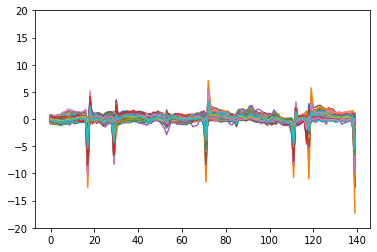

In [ ]:
visualize_select_plot(X, 14)

In [ ]:
def visualize_select_samples(dataset, idx, num_rows, num_cols, plot_title):

  fig, axs = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (20, num_rows * 4))
  fig.tight_layout(h_pad = 4)
  fig.suptitle(plot_title, fontsize=18, y = 0.95)
  plt.subplots_adjust(top = 0.9)

  for idx, ax in zip(idx, axs.ravel()):
    sample = dataset[idx]
    for row_id in range(len(sample)):
      ax.plot(range(140), sample[row_id])
    ax.set_ylim(-20, 20)
    ax.set_title(f"sample: {idx}")
  plt.show()

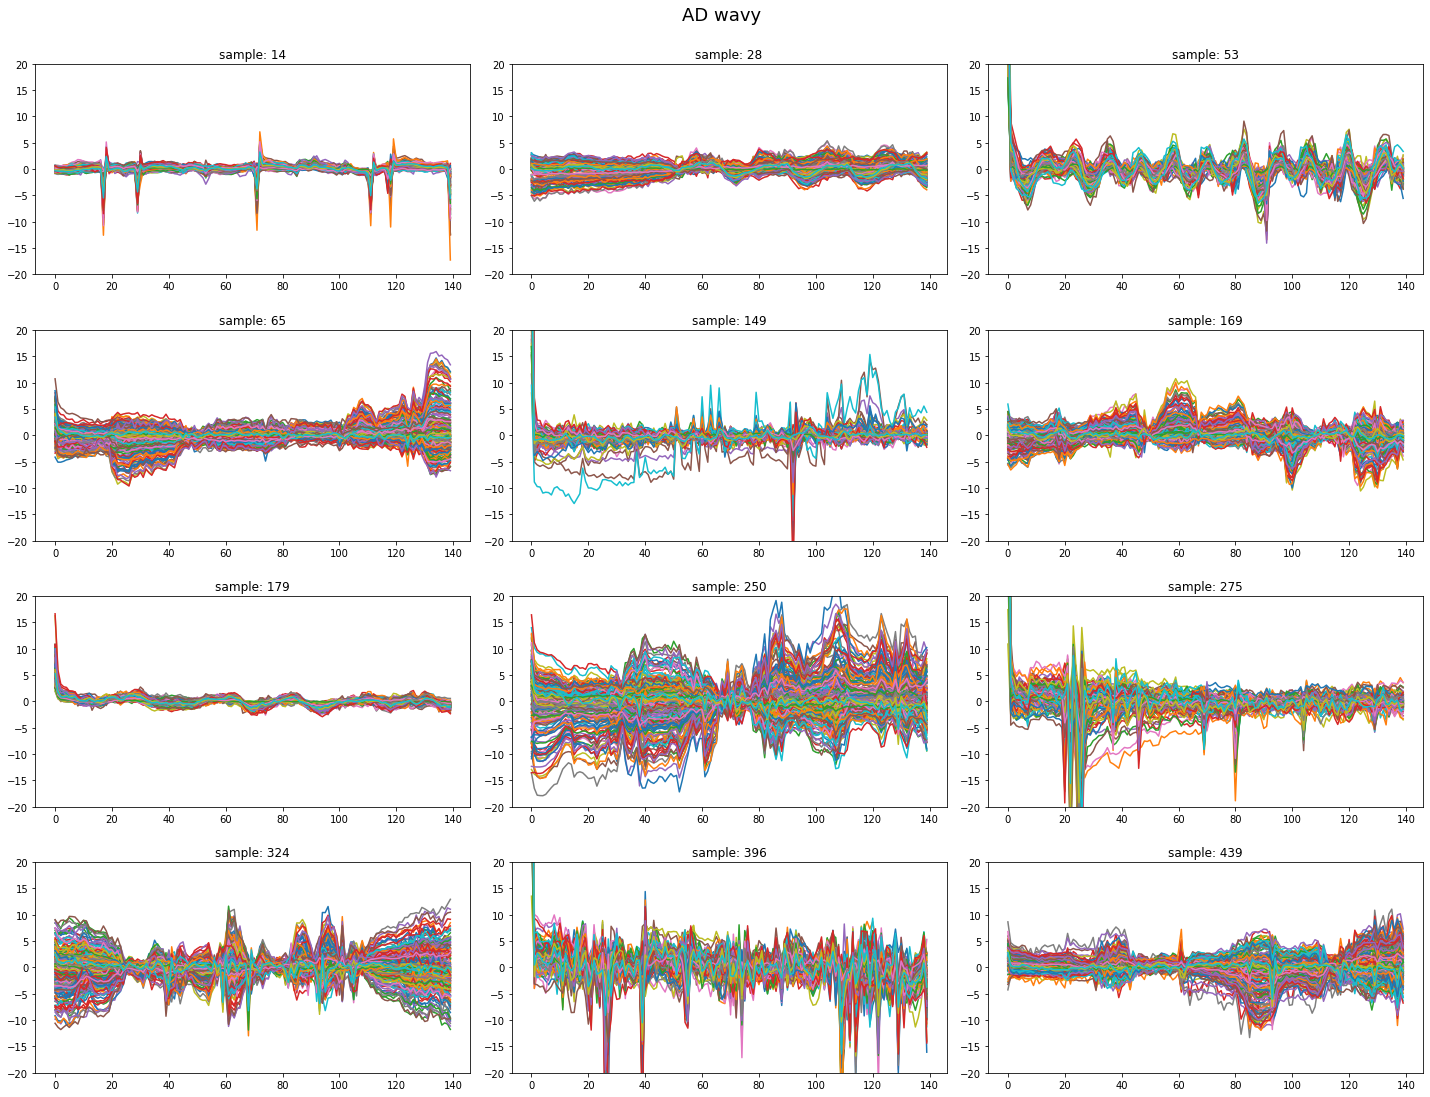

In [ ]:
ad_w_irreg = [14, 28, 53, 65, 149, 169, 179, 250, 275, 324, 396, 439]
visualize_select_samples(X, ad_w_irreg, 4, 3, 'AD wavy')

### Despking

#### Test

In [ ]:
test_x = X[14, :, :].copy()

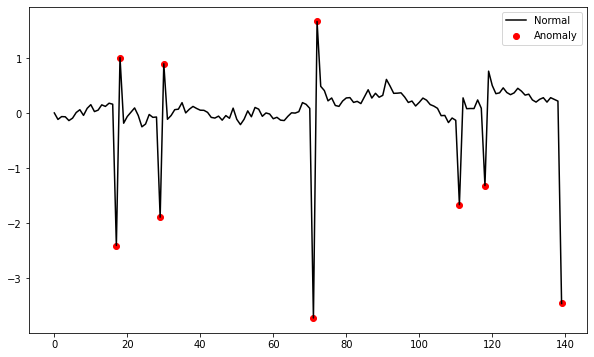

In [ ]:
data = pd.DataFrame(test_x[0])

model =  IsolationForest(contamination = 0.06)
model.fit(data)

data['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = data.loc[data['anomaly'] == -1, 0] #anomaly

ax.plot(data.index, data[[0]], color='black', label = 'Normal')
ax.scatter(a.index, a.values, color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [ ]:
index_list = []

for row_id in tqdm(range(len(test_x))):
  data = pd.DataFrame(test_x[row_id])

  model = IsolationForest(contamination = 0.06)
  model.fit(data)

  data['anomaly'] = model.predict(data)

  a = data.loc[data['anomaly'] == -1, 0] #anomaly

  index_list = index_list + list(a.index.values)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
all_indices = np.unique(index_list, return_counts = True)
print(all_indices)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  21,  22,  24,  25,  26,  27,  29,
        30,  31,  32,  34,  36,  37,  38,  39,  40,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  58,  65,  68,  69,  70,
        71,  72,  73,  74,  75,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 117, 118, 119, 123, 126,
       138, 139]), array([  1,   2,   1,   1,   3,   9,   3,   1,   5,   8,   9,   4,   1,
         2,   2,   1,   7, 179, 112,   1,   1,   7,   1,   1,   3, 177,
        58,   3,   6,   1,   1,   6,   8,   6,   7,   1,   3,   2,   1,
         4,   2,   4,   1,   2,   4,  45,  11,   1,   1,   5,   7,  13,
       166,  95,   3,   7,   2,  12,  16,   2,   3,   9,   1,  20,   9,
         5,  10,   7,   2,   1,   1,   7,   1,   6,   5,   2,   1,   1,
         3,   8,   1,   6,  31, 194,  15,   

In [ ]:
outlier_indices_indices = np.where(all_indices[1] > 50)

In [ ]:
outlier_indices = all_indices[0][outlier_indices_indices]
outlier_indices

array([ 17,  18,  29,  30,  71,  72, 111, 117, 118, 139])

In [ ]:
for row_id in tqdm(range(len(test_x))):
  data = test_x[row_id]

  for index in outlier_indices:
    if index != 0 and index != len(data) - 1:
      replacement_mean = (data[index - 1] + data[index + 1]) / 2
      test_x[row_id][index] = replacement_mean
    elif index == 0:
      test_x[row_id][index] = data[index + 1]
    elif index == len(data) - 1:
      test_x[row_id][index] = data[index - 1]

  0%|          | 0/200 [00:00<?, ?it/s]

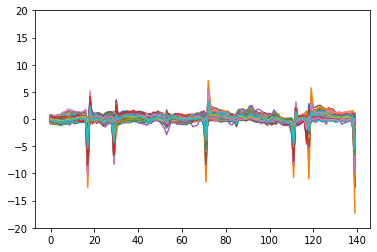

In [ ]:
for row_id in range(X[14].shape[0]):
  plt.plot(range(140), X[14][row_id])
plt.ylim(-20, 20);

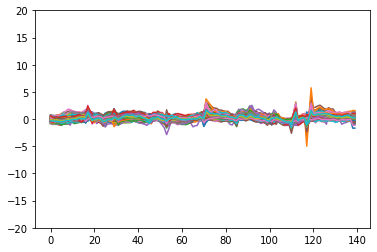

In [ ]:
for row_id in range(test_x.shape[0]):
  plt.plot(range(140), test_x[row_id])
plt.ylim(-20, 20);

#### Applying despking to all samples

In [ ]:
def outlier_removal_isolation_forest(sample_id, dataset, contamination, outlier_threshold):

  X_data = dataset[sample_id, :, :].copy()

  index_list = []

  for row_id in range(X_data.shape[0]):

    data = pd.DataFrame(X_data[row_id])
    model = IsolationForest(contamination = contamination)
    model.fit(data)
    data['anomaly'] = model.predict(data)
    anomalies = data.loc[data['anomaly'] == -1, 0]
    index_list = index_list + list(anomalies.index.values)


  all_indices = np.unique(index_list, return_counts = True)
  outlier_indices_indices = np.where(all_indices[1] > outlier_threshold)
  outlier_indices = all_indices[0][outlier_indices_indices]


  for row_id in range(X_data.shape[0]):

    data = X_data[row_id]

    for index in outlier_indices:

      if index != 0 and index != len(data) - 1:
        replacement_mean = (data[index - 1] + data[index + 1]) / 2
        X_data[row_id][index] = replacement_mean
      elif index == 0:
        X_data[row_id][index] = data[index + 1]
      elif index == len(data) - 1:
        X_data[row_id][index] = data[index - 1]

  return X_data

In [ ]:
X_despiked = Parallel(n_jobs = 2)(
    delayed(outlier_removal_isolation_forest)(sample_id, X, contamination = 0.06, outlier_threshold = 50) for sample_id in tqdm(range(X.shape[0]))
)

  0%|          | 0/1185 [00:00<?, ?it/s]

In [ ]:
X_despiked = np.stack(X_despiked, axis = 0)

In [ ]:
for row_id in range(X[14].shape[0]):
  plt.plot(range(140), X[14][row_id])
plt.ylim(-20, 20);

In [ ]:
visualize_select_samples(X_despiked, ad_w_irreg, 4, 3, 'AD wavy')

### Save despiked dataset

In [ ]:
np.save('scaled_datasets_as_np_arrays/X_train_val_despiked.npy', X_despiked)
# del X_despiked
# gc.collect()

# Feature engineering
* Wavelet transformations
* Feature extraction

## Import despiked and scaled data

In [ ]:
# Scaled_data
X = np.load('scaled_datasets_as_np_arrays/X_final_train_val.npy', mmap_mode = 'c')
y = np.load('scaled_datasets_as_np_arrays/y_final_train_val.npy', mmap_mode = 'c')

# X_train = np.load('scaled_datasets_as_np_arrays/X_train.npy', mmap_mode = 'c')
# y_train = np.load('scaled_datasets_as_np_arrays/y_train.npy', mmap_mode = 'c')

# X_val = np.load('scaled_datasets_as_np_arrays/X_val.npy', mmap_mode = 'c')
# y_val = np.load('scaled_datasets_as_np_arrays/y_val.npy', mmap_mode = 'c')

# X_test = np.load('scaled_datasets_as_np_arrays/X_test.npy', mmap_mode = 'c')
# y_test = np.load('scaled_datasets_as_np_arrays/y_test.npy', mmap_mode = 'c')

## Feature extraction

### Minimum features

In [ ]:
features_df_min = get_ts_features(X, y.astype(str), features = "min")
features_df_min.to_csv('./features_data/features_final_df_min.csv', index = False)

Feature Extraction: 100%|██████████| 10/10 [06:17<00:00, 37.72s/it]


### Custom features

#### Features to be extracted

In [ ]:
fc_parameters = {
    "absolute_sum_of_changes": None,
    "first_location_of_maximum": None,
    "first_location_of_minimum": None,
    "longest_strike_above_mean": None,
    "longest_strike_below_mean": None,
    "approximate_entropy": [
                    {"m": 2, "r": r} for r in [0.1, 0.5, 0.9] # default: [0.1, 0.3, 0.5, 0.7, 0.9]
                ], #high_comp_cost
    "c3": [{"lag": lag} for lag in [1, 3]], # default: range(1, 4)
    "cid_ce": [{"normalize": True}, {"normalize": False}],
    "cwt_coefficients": [
                    {"widths": width, "coeff": coeff, "w": w}
                    for width in [(2, 15)] # default: [(2, 5, 10, 20)]
                    for coeff in range(0, 15, 3) # default: range(15)
                    for w in (2, 15) # default: (2, 5, 10, 20)
                ],
    "fft_aggregated": [
                    {"aggtype": s} for s in ["skew", "kurtosis"] # default: ["centroid", "variance", "skew", "kurtosis"]
                ],
    "fft_coefficient": [
                    {"coeff": k, "attr": a}
                    for a, k in product(["real", "imag", "abs", "angle"], range(0, 100, 10)) # default: product(["real", "imag", "abs", "angle"], range(100)
                ],

    "fourier_entropy": [{"bins": x} for x in [2, 10, 100]], # default: [2, 3, 5, 10, 100]
    "index_mass_quantile": [
                    {"q": q} for q in [0.1, 0.3, 0.6, 0.8] # default: [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]
                ],
    "lempel_ziv_complexity": [{"bins": x} for x in [2, 10, 100]], # default: [2, 3, 5, 10, 100]
    "ratio_beyond_r_sigma":  [
                    {"r": x} for x in [0.5, 1.5, 2.5, 5, 10] # default: [0.5, 1, 1.5, 2, 2.5, 3, 5, 6, 7, 10]
                ],
    "spkt_welch_density": [{"coeff": coeff} for coeff in [2, 5, 8]]
}

#### Noisy data

In [ ]:
X_df = to_tsfresh_df(X)

if y.ndim == 1:
  y = y.reshape(-1,1)

In [ ]:
features_df_custom = extract_features(X_df, column_id= "id", n_jobs = 2, default_fc_parameters = fc_parameters)

Feature Extraction: 100%|██████████| 10/10 [47:16<00:00, 283.63s/it]


In [ ]:
features_df_custom['target'] = y

features_df_custom.to_csv('./features_data/features_final_df_custom.csv', index = False)

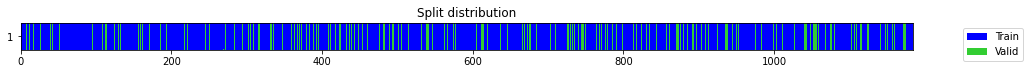

In [ ]:
# Saving a cleaned and scaled version of the features data

features_df_custom_mod = features_df_custom.iloc[:, :-1].dropna(axis = 1)

splits = get_splits(y, valid_size = .2, stratify = True, random_state = 42, shuffle = True)

train_indices = splits[0]

features_df_custom_mod_train = features_df_custom_mod.iloc[train_indices, :]

scaler = StandardScaler()

scaler.fit(features_df_custom_mod_train)

features_df_custom_mod_scaled = scaler.transform(features_df_custom_mod)

features_df_custom_mod_scaled_df = pd.DataFrame(features_df_custom_mod_scaled)

features_df_custom_mod_scaled_df['target'] = y

features_df_custom_mod_scaled_df.to_csv('./features_data/features_final_df_custom_mod.csv', index = False)

## Signal transformation

### Frequency ranges
* I believe ADNI used TR = 2 s (0.5 Hz) https://link.springer.com/article/10.1007/s11682-016-9539-0
* Total acquisition time: 140 * 3 = 420 s
* Downsampling across the whole range will lead to 1 / 420 = 0.002
* max frequency is 1 / 3 = 0.33 Hz
* Nyquist frequency limits this to half the sample frequency? (0.165)

In [ ]:
# Parameters
wvt_max_freq = "half"
despiked = False

In [ ]:
if wvt_max_freq == 'half':
  frequency_range = (0.05, 0.165)
elif wvt_max_freq == 'full':
  frequency_range = (0.05, 0.33)

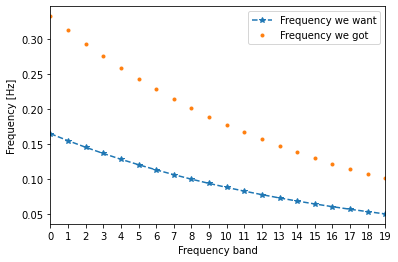

In [ ]:
number_of_frequencies = 20
dt = 3

frequency_range_np = np.array(frequency_range)

s_spacing = (1.0 / (number_of_frequencies - 1)) * np.log2(
    frequency_range_np.max() / frequency_range_np.min()
)

scale = np.power(2, np.arange(0, number_of_frequencies) * s_spacing)

frequency_axis_np = frequency_range_np.min() * np.flip(scale)
plt.plot(frequency_axis_np, "--*")

frequency_axis = pywt.scale2frequency("cmor1.5-1.0", scale) / dt

plt.plot(frequency_axis, ".")
plt.legend(["Frequency we want", "Frequency we got"])
plt.xlim([0, number_of_frequencies - 1])
plt.xticks(np.arange(0, number_of_frequencies))
plt.ylabel("Frequency [Hz]")
plt.xlabel("Frequency band")
plt.show()

### Function for applying the wavelet transformations

In [ ]:
def create_cwt_images(X, scale_range, wavelet_name = 'morl', rescale=True, upsample=False, rescale_steps=30, rescale_scales=30):
    """
    Generate Continuous Wavelet Transform (CWT) array.

    Parameters
    ----------
        X : numpy.ndarray
            an array to be processed by the CWT transform, and
            must have a 3D shape of (samples,timeseries,features).
        scale_range : list of float
            the start and stop scale for the scale_range.
        wavelet_name : str, default 'morl'
            the mother wavelet that the CWT transform should use.
        rescale : bool, default True
            whether to rescale the output of the CWT transform to other dimensions
        upsample : bool, default False
            doubles the samples per timetrace
        rescale_scales : int, default 30
            the size to rescale the scales to if 'rescale' is set to True
        rescale_steps : int, default 30
            the size to rescale the steps to if 'rescale' is set to True

    Returns
    -------
        X_cwt : numpy.ndarray
            4D array of (samples, scales, timesteps, features).
    """
    # Reshape from (samples, features, timeseries) to (samples, timeseries, features)
    X = np.transpose(X, axes = (0, 2, 1))

    samples = X.shape[0]
    steps = X.shape[1]
    sensors = X.shape[2]

    x_dim = steps
    y_dim = len(scale_range)

    if upsample:
        x_dim = x_dim * 2

    if rescale:
        x_dim = rescale_steps
        y_dim = rescale_scales


    # prepare the output array
    X_cwt = np.ndarray(shape=(samples, y_dim, x_dim, sensors), dtype = 'float32')

    for sample in tqdm(range(samples),desc = 'Creating CWT images: '):

        for sensor in range(sensors):
            series = X[sample, :, sensor]
            # upsample
            if upsample:
                x = np.linspace(1,len(series),len(series)*2)
                xp = np.arange(1,len(series)+1,dtype='float32')
                series = np.interp(x, xp, series)
            # continuous wavelet transform
            coeffs, _ = pywt.cwt(series, scale_range, wavelet_name)
            # resize the 2D cwt coeffs
            if rescale:
                coeffs = resize(coeffs, (y_dim, x_dim), mode = 'constant')

            X_cwt[sample,:,:,sensor] = coeffs

            # del series, coeffs
            # gc.collect()

    return X_cwt

### Generate and save wavelet-transformed datasets

In [ ]:
if wvt_max_freq == 'half':
  X_cwt = create_cwt_images(X, scale, wavelet_name = "morl", rescale = False, upsample = False)
  print(f"Shape (samples, scales, time, features) of X_cwt: {X_cwt.shape}")
  np.save('wavelet_transformed_data/X_cwt_final_half.npy', X_cwt)
  del X_cwt
  gc.collect()

elif wvt_max_freq == 'full':
  X_cwt = create_cwt_images(X, scale, wavelet_name = "morl", rescale = False, upsample = False)
  print(f"Shape (samples, scales, time, features) of X_cwt: {X_cwt.shape}")
  np.save('wavelet_transformed_data/X_cwt_final_full.npy', X_cwt)
  del X_cwt
  gc.collect()

Creating CWT images:   0%|          | 0/1185 [00:00<?, ?it/s]

Shape (samples, scales, time, features) of X_cwt: (1185, 20, 140, 200)


### Determining the value of each transformation

Based on the results from the hyperparameter sweeps, some of the transformations seem to train the model better and they probably contain more information. So we could limit our ensemble training only to these transformations to reduce training time.

In [ ]:
# Number of epochs the training was allowed to run by the EarlyStopping callback on each of the 20
# wavelet transformations in the https://wandb.ai/masadeghi6/fmri-dementia-wt-fe-multimodal-seven/sweep/m8hm70a8
# WandB sweep

num_epochs_array = np.array([[27,9,9,27,8,29,26,8,29,23,24,29,29,27,24,25,29,24,25,29],
                            [9,29,20,21,21,24,29,29,29,9,15,17,25,24,26,28,17,16,20,23],
                            [5,5,5,6,16,5,15,17,19,16,12,5,19,11,5,11,20,16,12,12],
                            [5,25,6,7,5,13,18,22,24,5,5,21,12,7,12,29,23,11,7,19],
                            [5,8,5,21,19,23,6,17,12,13,5,11,13,14,5,7,5,19,5,21],
                            [22,5,5,21,24,5,5,19,5,23,7,15,14,26,6,11,5,12,5,6],
                            [6,5,6,5,17,5,19,19,6,5,6,17,15,19,6,5,5,8,5,16],
                            [7,8,6,5,19,21,17,19,5,7,5,16,13,11,5,5,13,11,5,11],
                            [7,7,5,7,5,6,6,23,19,13,5,23,5,5,6,12,17,23,5,14],
                            [7,7,25,7,5,16,5,5,17,5,5,12,5,14,7,15,6,6,14,6],
                            [5,7,19,25,18,5,22,7,7,5,5,14,5,5,5,18,5,14,5,5],
                            [5,19,5,5,8,22,5,8,7,6,7,6,6,5,5,5,14,6,6,7]]
)

In [ ]:
np.mean(num_epochs_array, axis = 0)

array([ 9.16666667, 11.16666667,  9.66666667, 13.08333333, 13.75      ,
       14.5       , 14.41666667, 16.08333333, 14.91666667, 10.83333333,
        8.41666667, 15.5       , 13.41666667, 14.        ,  9.33333333,
       14.25      , 13.25      , 13.83333333,  9.5       , 14.08333333])

In [ ]:
Importance_index_stingy = [3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17, 19]
Importance_index_lax = [1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19]

# Clinical data - imaging_project
* Preprocessing
* EDA

In [ ]:
clinical_data = pd.read_csv("/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/clinical_data/final_raw_clinical_data.csv")

clinical_data.head()

,class,patient_orig_id,patient_id,study_num,date_of_study,date_of_birth,age,biological_sex,education,mmse_total_score,...,faq_taxes,faq_shopping,faq_games,faq_stove,faq_mealprep,faq_events,faq_payattn,faq_remdates,faq_travel,faq_total
0,AD,002_S_5018,1.txt,1.0,10/29/2012,6/15/1939,73.0,1.0,17.0,23.0,...,5.0,4.0,3.0,0.0,4.0,3.0,4.0,5.0,0.0,17.0
1,AD,002_S_5018,2.txt,2.0,11/28/2012,6/15/1939,73.0,1.0,17.0,23.0,...,5.0,4.0,3.0,0.0,4.0,3.0,4.0,5.0,0.0,17.0
2,AD,002_S_5018,3.txt,3.0,5/30/2013,6/15/1939,73.0,1.0,17.0,24.0,...,5.0,4.0,3.0,2.0,3.0,4.0,4.0,5.0,0.0,18.0
3,AD,002_S_5018,4.txt,4.0,11/26/2013,6/15/1939,74.0,1.0,17.0,22.0,...,5.0,3.0,2.0,3.0,5.0,3.0,4.0,4.0,0.0,17.0
4,AD,003_S_6264,5.txt,1.0,6/6/2018,3/15/1963,55.0,1.0,12.0,23.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0


In [ ]:
clinical_data = clinical_data.drop([
    'patient_orig_id',
    'patient_id',
    'study_num',
    'date_of_study',
    'date_of_birth'],
    axis = 1)

clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   class                       1324 non-null   object 
 1   age                         1295 non-null   float64
 2   biological_sex              1297 non-null   float64
 3   education                   1297 non-null   float64
 4   mmse_total_score            1252 non-null   float64
 5   cdr_total_score             1152 non-null   float64
 6   digit_span_fw               574 non-null    float64
 7   digit_span_bw               574 non-null    float64
 8   boston_naming_test_total    1011 non-null   float64
 9   letter_verbal_fluency_test  1181 non-null   float64
 10  gds_score                   1249 non-null   float64
 11  faq_bills                   1009 non-null   float64
 12  faq_taxes                   1006 non-null   float64
 13  faq_shopping                1009 

In [ ]:
# In some columns, unavailable data have been entered as negative values. Replace these with np.nan
numerical_clinical_data = clinical_data._get_numeric_data()
numerical_clinical_data[numerical_clinical_data < 0] = np.nan

# In the education column, unavailable data has been entered as 99 in some rows
clinical_data.loc[clinical_data["education"] == 99, "education"] = np.nan

# two NaN rows are included at the end of the dataset
clinical_data = clinical_data.drop([1324, 1325], axis = 0)

clinical_data['class'] = clinical_data['class'].astype('category')
clinical_data['biological_sex'] = clinical_data['biological_sex'].astype('category')

### Handle the missing data

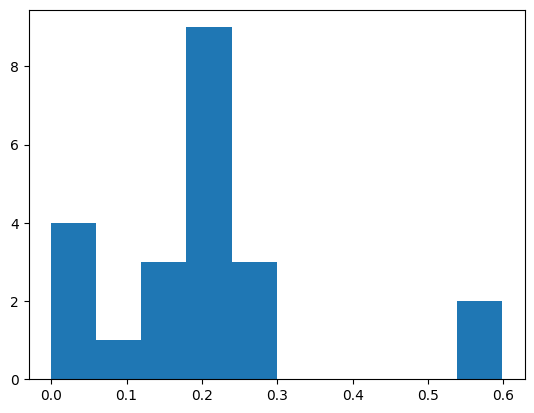

In [ ]:
# Determining the extent of missing data in the dataset
missing_perc = []

for i, col in enumerate(clinical_data.columns):
  percentage = clinical_data[col].isnull().mean()
  missing_perc.append((i, col, percentage))

missing_perc.sort(key = lambda x: x[2], reverse = True)

plt.hist([i[2] for i in missing_perc], bins = 10)
plt.show()

In [ ]:
for i in missing_perc:
  print(i)

(6, 'digit_span_fw', 0.5981873111782477)
(7, 'digit_span_bw', 0.5913897280966768)
(8, 'boston_naming_test_total', 0.25075528700906347)
(12, 'faq_taxes', 0.24018126888217523)
(21, 'faq_total', 0.24018126888217523)
(11, 'faq_bills', 0.23791540785498488)
(13, 'faq_shopping', 0.23791540785498488)
(14, 'faq_games', 0.23791540785498488)
(15, 'faq_stove', 0.23791540785498488)
(16, 'faq_mealprep', 0.23791540785498488)
(17, 'faq_events', 0.23791540785498488)
(18, 'faq_payattn', 0.23791540785498488)
(19, 'faq_remdates', 0.23791540785498488)
(20, 'faq_travel', 0.23791540785498488)
(9, 'letter_verbal_fluency_test', 0.1729607250755287)
(10, 'gds_score', 0.13821752265861026)
(5, 'cdr_total_score', 0.1351963746223565)
(4, 'mmse_total_score', 0.07779456193353475)
(3, 'education', 0.02945619335347432)
(1, 'age', 0.02190332326283988)
(2, 'biological_sex', 0.02039274924471299)
(0, 'class', 0.0)


Based on these numbers, we have to remove the digit_span_fw and digit_span_bw columns. For the other columns, let's check if the percentage of missing data is dependent on other features of the dataset or not?

### Check if missingness is dependent on disease class or not?

In [ ]:
clinical_data = clinical_data.drop(['digit_span_fw', 'digit_span_bw'], axis = 1)

# Determine if the distribution of missing data is different between groups:
class_categories = clinical_data['class'].unique()

class_dist_missing = pd.DataFrame()
class_dist_missing['columns'] = clinical_data.columns

for cat in class_categories:
  data_subset = clinical_data[clinical_data['class'] == cat]

  missing_perc = []

  for i, col in enumerate(data_subset.columns):
    percentage = data_subset[col].isnull().mean()
    missing_perc.append(percentage)

  class_dist_missing[cat] = missing_perc

class_dist_missing

,columns,AD,FTD,HC,MCI
0,class,0.000000,0.000000,0.000000,0.000000
1,age,0.000000,0.055416,0.004963,0.014205
2,biological_sex,0.000000,0.055416,0.004963,0.008523
3,education,0.000000,0.070529,0.019851,0.008523
4,mmse_total_score,0.000000,0.181360,0.062035,0.017045
5,cdr_total_score,0.000000,0.156171,0.275434,0.017045
6,boston_naming_test_total,0.598837,0.188917,0.173697,0.238636
7,letter_verbal_fluency_test,0.063953,0.249370,0.223325,0.082386
8,gds_score,0.005814,0.332494,0.106700,0.019886
9,faq_bills,0.063953,0.400504,0.320099,0.045455


In [ ]:
from sklearn.impute import MissingIndicator

clinical_data_w_missing = clinical_data.copy()

colnames = clinical_data.columns[1:]
for col in colnames:
  new_name = "missing_" + col
  indicator = MissingIndicator()
  clinical_data_w_missing[new_name] = indicator.fit_transform(np.array(clinical_data_w_missing[col]).reshape(-1, 1)).astype(int)

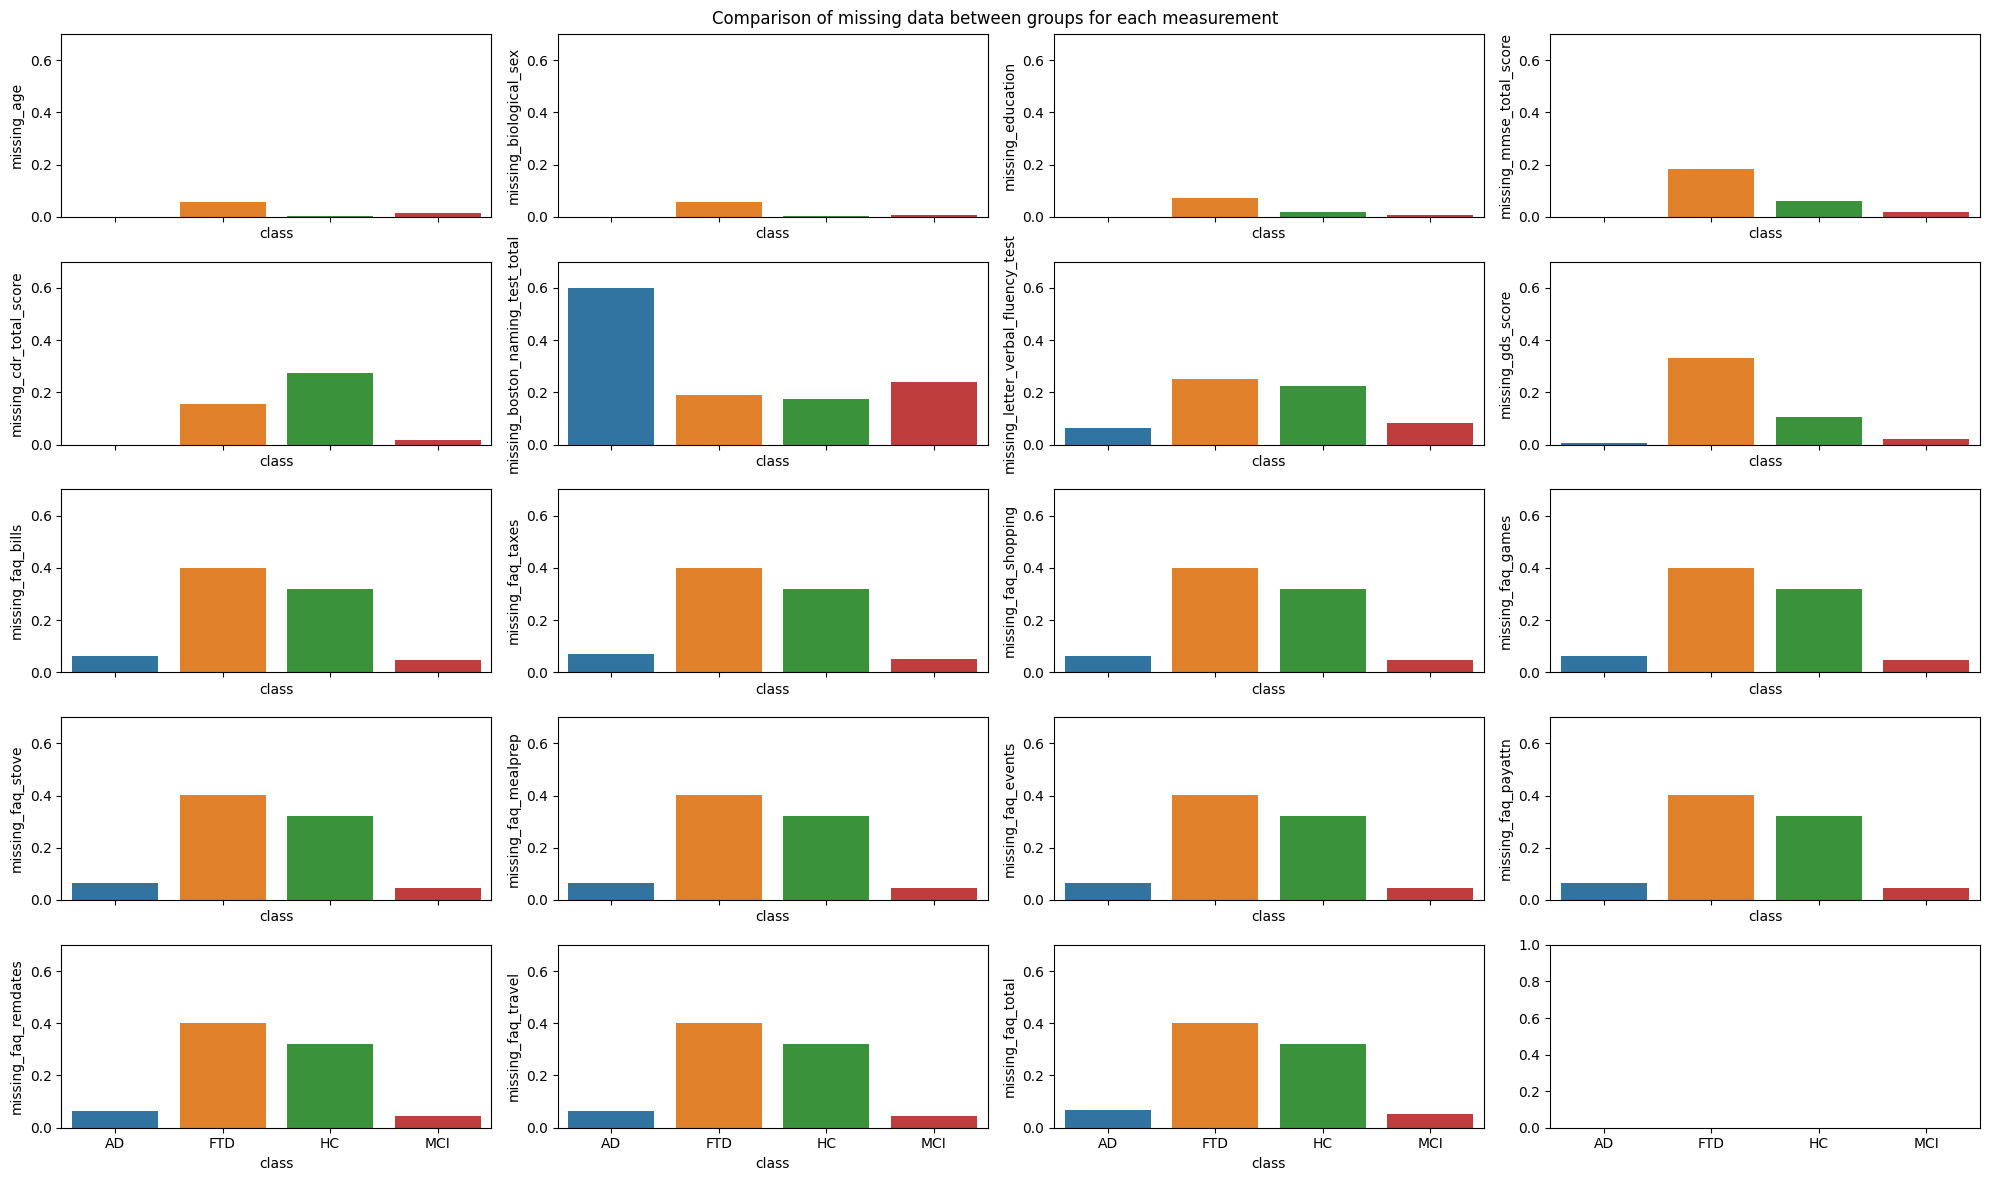

In [ ]:
missing_columns = clinical_data_w_missing.columns[20:]

figure, axes = plt.subplots(5, 4, sharex = True, figsize=(20, 12))
figure.suptitle('Comparison of missing data between groups for each measurement')

for i, col in enumerate(missing_columns):
  sns.barplot(ax = axes.ravel()[i], x = 'class', y = col, estimator = lambda x: sum(x == 1)*1/len(x), errorbar = None, data = clinical_data_w_missing)
  axes.ravel()[i].set_ylim(0, 0.7)

figure.tight_layout()

### Check if the available values contain information that could help with classifying the groups

In [ ]:
numeric_columns = clinical_data._get_numeric_data().columns

figure, axes = plt.subplots(5, 4, sharex = True, figsize=(20, 12))
figure.suptitle('Comparison of features between groups')

for i, col in enumerate(numeric_columns):
  sns.boxplot(ax = axes.ravel()[i], x = 'class', y = col, data = clinical_data)

figure.tight_layout()

### Split data into predictor (X) and target (y)

In [ ]:
y = clinical_data["class"]
X = clinical_data.drop("class", axis = 1)

In [ ]:
# Splitting out the test set
from sklearn.model_selection import train_test_split

labels_train_val, labels_test = train_test_split(y, test_size = 0.1,
                                            shuffle = True, random_state = 42,
                                            stratify = y)

# Train/val split
labels_train, labels_val = train_test_split(labels_train_val, test_size = 0.2,
                                            shuffle = True, random_state = 42,
                                            stratify = labels_train_val)

In [ ]:
y.value_counts()/len(y), labels_val.value_counts()/len(labels_val), labels_train.value_counts()/len(labels_train)

(HC     0.304381
 FTD    0.299849
 MCI    0.265861
 AD     0.129909
 Name: class, dtype: float64,
 HC     0.305439
 FTD    0.301255
 MCI    0.263598
 AD     0.129707
 Name: class, dtype: float64,
 HC     0.303571
 FTD    0.299370
 MCI    0.266807
 AD     0.130252
 Name: class, dtype: float64)

In [ ]:
X_train = X.loc[labels_train.index, :]
X_val = X.loc[labels_val.index, :]
X_train_val = X.loc[labels_train_val.index, :]
X_test = X.loc[labels_test.index, :]

### Impute features within each class

In [ ]:
AD_train = X.loc[labels_train[labels_train == "AD"].index, :]
FTD_train = X.loc[labels_train[labels_train == "FTD"].index, :]
HC_train = X.loc[labels_train[labels_train == "HC"].index, :]
MCI_train = X.loc[labels_train[labels_train == "MCI"].index, :]

AD_val = X.loc[labels_val[labels_val == "AD"].index, :]
FTD_val = X.loc[labels_val[labels_val == "FTD"].index, :]
HC_val = X.loc[labels_val[labels_val == "HC"].index, :]
MCI_val = X.loc[labels_val[labels_val == "MCI"].index, :]

AD_test = X.loc[labels_test[labels_test == "AD"].index, :]
FTD_test = X.loc[labels_test[labels_test == "FTD"].index, :]
HC_test = X.loc[labels_test[labels_test == "HC"].index, :]
MCI_test = X.loc[labels_test[labels_test == "MCI"].index, :]

In [ ]:
from sklearn.impute import SimpleImputer

class_categories = clinical_data['class'].unique()

data_groups = [(AD_train, AD_val, AD_test),
               (FTD_train, FTD_val, FTD_test),
               (HC_train, HC_val, HC_test),
               (MCI_train, MCI_val, MCI_test)]

imputed_data_groups = []

for group in data_groups:
  train = group[0]
  train_index = train.index
  val = group[1]
  val_index = val.index
  test = group[2]
  test_index = test.index

  # numeric data
  train_n = train.drop("biological_sex", axis = 1)
  val_n = val.drop("biological_sex", axis = 1)
  test_n = test.drop("biological_sex", axis = 1)
  numeric_columns = train_n.columns
  imputer = SimpleImputer(strategy = 'mean')
  imputer.fit(train_n)
  train_n = imputer.transform(train_n).astype(np.int64)
  val_n = imputer.transform(val_n).astype(np.int64)
  test_n = imputer.transform(test_n).astype(np.int64)

  # categorical data
  train_c = train["biological_sex"]
  val_c = val["biological_sex"]
  test_c = test["biological_sex"]
  imputer = SimpleImputer(strategy = 'most_frequent')
  imputer.fit(np.array(train_c).reshape(-1, 1))
  train_c = imputer.transform(np.array(train_c).reshape(-1, 1))
  val_c = imputer.transform(np.array(val_c).reshape(-1, 1))
  test_c = imputer.transform(np.array(test_c).reshape(-1, 1))

  train_n_df = pd.DataFrame(train_n, index = train_index, columns = numeric_columns)
  val_n_df = pd.DataFrame(val_n, index = val_index, columns = numeric_columns)
  test_n_df = pd.DataFrame(test_n, index = test_index, columns = numeric_columns)

  train_n_df.insert(loc = 1, column = "biological_sex", value = pd.Categorical(np.squeeze(train_c.astype(object))))
  val_n_df.insert(loc = 1, column = "biological_sex", value = pd.Categorical(np.squeeze(val_c.astype(object))))
  test_n_df.insert(loc = 1, column = "biological_sex", value = pd.Categorical(np.squeeze(test_c.astype(object))))

  new_group = (train_n_df, val_n_df, test_n_df)
  imputed_data_groups.append(new_group)

In [ ]:
X_train.loc[labels_train[labels_train == "AD"].index, :] = imputed_data_groups[0][0]
X_train.loc[labels_train[labels_train == "FTD"].index, :] = imputed_data_groups[1][0]
X_train.loc[labels_train[labels_train == "HC"].index, :] = imputed_data_groups[2][0]
X_train.loc[labels_train[labels_train == "MCI"].index, :] = imputed_data_groups[3][0]

X_val.loc[labels_val[labels_val == "AD"].index, :] = imputed_data_groups[0][1]
X_val.loc[labels_val[labels_val == "FTD"].index, :] = imputed_data_groups[1][1]
X_val.loc[labels_val[labels_val == "HC"].index, :] = imputed_data_groups[2][1]
X_val.loc[labels_val[labels_val == "MCI"].index, :] = imputed_data_groups[3][1]

X_test.loc[labels_test[labels_test == "AD"].index, :] = imputed_data_groups[0][2]
X_test.loc[labels_test[labels_test == "FTD"].index, :] = imputed_data_groups[1][2]
X_test.loc[labels_test[labels_test == "HC"].index, :] = imputed_data_groups[2][2]
X_test.loc[labels_test[labels_test == "MCI"].index, :] = imputed_data_groups[3][2]

### Feature engineering
* MinMax normalization of numerical features
* OneHotEncoding of categorical features

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

encoder = OneHotEncoder(sparse = False)
scaler = MinMaxScaler()

encoder.fit(np.array(X_train["biological_sex"]).reshape(-1, 1))
train_cat = encoder.transform(np.array(X_train["biological_sex"]).reshape(-1, 1))
val_cat = encoder.transform(np.array(X_val["biological_sex"]).reshape(-1, 1))
test_cat = encoder.transform(np.array(X_test["biological_sex"]).reshape(-1, 1))

scaler.fit(X_train.drop("biological_sex", axis = 1))
train_cont = scaler.transform(X_train.drop("biological_sex", axis = 1))
val_cont = scaler.transform(X_val.drop("biological_sex", axis = 1))
test_cont = scaler.transform(X_test.drop("biological_sex", axis = 1))

X_train_clinical = np.hstack((train_cont, train_cat))
X_val_clinical = np.hstack((val_cont, val_cat))
X_test_clinical = np.hstack((test_cont, test_cat))

### Test the informativeness of clinical data using the RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train_clinical, labels_train)
val_pred = rfc.predict(X_val_clinical)
test_pred = rfc.predict(X_test_clinical)

encoder = LabelEncoder()

print("Balanced accuracy in validation set:", balanced_accuracy_score(labels_val, val_pred))
print("Balanced accuracy in test set:", balanced_accuracy_score(labels_test, test_pred))


Balanced accuracy in validation set: 0.8990620331208046
Balanced accuracy in test set: 0.9259300061488009


In [ ]:
feature_names = list(numeric_columns) + ["biological_sex_1", "biological_sex_2"]

for pair in zip(feature_names, rfc.feature_importances_):
  print(pair)

('age', 0.0689896801644782)
('education', 0.037179634249214374)
('mmse_total_score', 0.04978259625330819)
('cdr_total_score', 0.011784916722044963)
('boston_naming_test_total', 0.23903134254494138)
('letter_verbal_fluency_test', 0.06730565258097589)
('gds_score', 0.03601983730126714)
('faq_bills', 0.04793657674328114)
('faq_taxes', 0.037568937769437)
('faq_shopping', 0.03626319100376904)
('faq_games', 0.01871412255423323)
('faq_stove', 0.029859530033586736)
('faq_mealprep', 0.02458115937420945)
('faq_events', 0.010421270680790328)
('faq_payattn', 0.03515830220645753)
('faq_remdates', 0.0646666638422228)
('faq_travel', 0.04898858628914285)
('faq_total', 0.12285275454041975)
('biological_sex_1', 0.0066195872416013705)
('biological_sex_2', 0.006275657904618644)


In [ ]:
# Remove boston_naming_test_total (too many missing data points in AD group) and faq tests (too many missing data points in the FTD group)

X_train_clinical_mod = np.hstack((X_train_clinical[:, :4], X_train_clinical[:, 5:7], X_train_clinical[:, -2:]))
X_val_clinical_mod = np.hstack((X_val_clinical[:, :4], X_val_clinical[:, 5:7], X_val_clinical[:, -2:]))
X_test_clinical_mod = np.hstack((X_test_clinical[:, :4], X_test_clinical[:, 5:7], X_test_clinical[:, -2:]))

rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train_clinical_mod, labels_train)
val_pred = rfc.predict(X_val_clinical_mod)
test_pred = rfc.predict(X_test_clinical_mod)

print(balanced_accuracy_score(labels_val, val_pred))
print(balanced_accuracy_score(labels_test, test_pred))

0.7974217747196093
0.8028207624513221


In [ ]:
feature_names_mod = ["age", "education", "mmse_total_score", "cdr_total_score",
                 "letter_verbal_fluency_test", "gds_score", "biological_sex_1", "biological_sex_2"]

for pair in zip(feature_names_mod, rfc.feature_importances_):
  print(pair)

('age', 0.21523272178921563)
('education', 0.1113703063865646)
('mmse_total_score', 0.19491883081589417)
('cdr_total_score', 0.07117342239864985)
('letter_verbal_fluency_test', 0.23926725543972185)
('gds_score', 0.13119617064670158)
('biological_sex_1', 0.01751512064364512)
('biological_sex_2', 0.019326171879607158)
